In [1]:
import numpy as np
from classification import MLP  
from regression import MLPRegressor 
    
class CombinedModel:
    def __init__(self, clf_model, reg_model):
        self.clf_model = clf_model
        self.reg_model = reg_model

    def predict(self, X):
        """輸入 X 為經緯度座標，輸出分類為 -999 或預測溫度"""
        y_clf = self.clf_model.predict(X)
        y_reg = self.reg_model.predict(X)

        # 合併輸出：陸地→預測溫度；海洋→-999
        result = np.where(y_clf == 1, y_reg, -999)
        return result

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 讀入分類資料
df_cls = pd.read_csv("classification_data.csv")  # (lon, lat, label)
X_cls = df_cls[['lon', 'lat']]
y_cls = df_cls['label']

# 標準化
scaler = StandardScaler()
X_cls = scaler.fit_transform(X_cls)

# 分割分類資料
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# 讀入迴歸資料
df_reg = pd.read_csv("regression_data.csv")  # (lon, lat, value)
X_reg = df_reg[['lon', 'lat']]
y_reg = df_reg['value']

# 標準化
X_reg = scaler.transform(X_reg)

# 分割迴歸資料
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [3]:
combined_model = CombinedModel(
    clf_model = MLP(),
    reg_model = MLPRegressor()
)

In [4]:
# 訓練分類模型
combined_model.clf_model.fit(X_cls_train, y_cls_train, X_cls_test, y_cls_test)

Epoch 0 | Train Loss: 0.7448 | Valid Loss: 0.7505
Epoch 100 | Train Loss: 0.6425 | Valid Loss: 0.6444
Epoch 200 | Train Loss: 0.5554 | Valid Loss: 0.5598
Epoch 300 | Train Loss: 0.5453 | Valid Loss: 0.5495
Epoch 400 | Train Loss: 0.5422 | Valid Loss: 0.5462
Epoch 500 | Train Loss: 0.5407 | Valid Loss: 0.5447
Epoch 600 | Train Loss: 0.5397 | Valid Loss: 0.5436
Epoch 700 | Train Loss: 0.5389 | Valid Loss: 0.5425
Epoch 800 | Train Loss: 0.5381 | Valid Loss: 0.5415
Epoch 900 | Train Loss: 0.5371 | Valid Loss: 0.5407
Epoch 1000 | Train Loss: 0.5361 | Valid Loss: 0.5397
Epoch 1100 | Train Loss: 0.5354 | Valid Loss: 0.5393
Epoch 1200 | Train Loss: 0.5350 | Valid Loss: 0.5391
Epoch 1300 | Train Loss: 0.5347 | Valid Loss: 0.5390
Epoch 1400 | Train Loss: 0.5344 | Valid Loss: 0.5388
Epoch 1500 | Train Loss: 0.5341 | Valid Loss: 0.5386
Epoch 1600 | Train Loss: 0.5340 | Valid Loss: 0.5385
Epoch 1700 | Train Loss: 0.5338 | Valid Loss: 0.5383
Epoch 1800 | Train Loss: 0.5336 | Valid Loss: 0.5383
Epoch

In [5]:
# 訓練回歸模型
combined_model.reg_model.fit(X_reg_train, y_reg_train, X_reg_test, y_reg_test)

Epoch 0 | Train Loss: 497.8738 | Valid Loss: 503.7775
Epoch 100 | Train Loss: 22.5237 | Valid Loss: 21.8970
Epoch 200 | Train Loss: 18.4907 | Valid Loss: 18.0444
Epoch 300 | Train Loss: 15.2287 | Valid Loss: 15.3896
Epoch 400 | Train Loss: 13.5111 | Valid Loss: 14.0035
Epoch 500 | Train Loss: 12.3821 | Valid Loss: 12.8739
Epoch 600 | Train Loss: 11.3184 | Valid Loss: 11.5974
Epoch 700 | Train Loss: 10.5400 | Valid Loss: 10.7297
Epoch 800 | Train Loss: 9.9148 | Valid Loss: 10.0605
Epoch 900 | Train Loss: 9.3794 | Valid Loss: 9.5244
Epoch 1000 | Train Loss: 8.9541 | Valid Loss: 9.1171
Epoch 1100 | Train Loss: 8.6580 | Valid Loss: 8.8978
Epoch 1200 | Train Loss: 8.3875 | Valid Loss: 8.6215
Epoch 1300 | Train Loss: 8.1650 | Valid Loss: 8.4364
Epoch 1400 | Train Loss: 7.9630 | Valid Loss: 8.2160
Epoch 1500 | Train Loss: 7.7506 | Valid Loss: 7.9766
Epoch 1600 | Train Loss: 7.5806 | Valid Loss: 7.8491
Epoch 1700 | Train Loss: 7.4438 | Valid Loss: 7.7462
Epoch 1800 | Train Loss: 7.3375 | Valid

In [6]:
y_combined = combined_model.predict(X_cls)

In [7]:
X_original = scaler.inverse_transform(X_cls)

In [8]:
results = np.column_stack((X_original, y_combined))

In [9]:
np.savetxt("results.csv", results, delimiter=",", header="lon,lat,value", comments='')

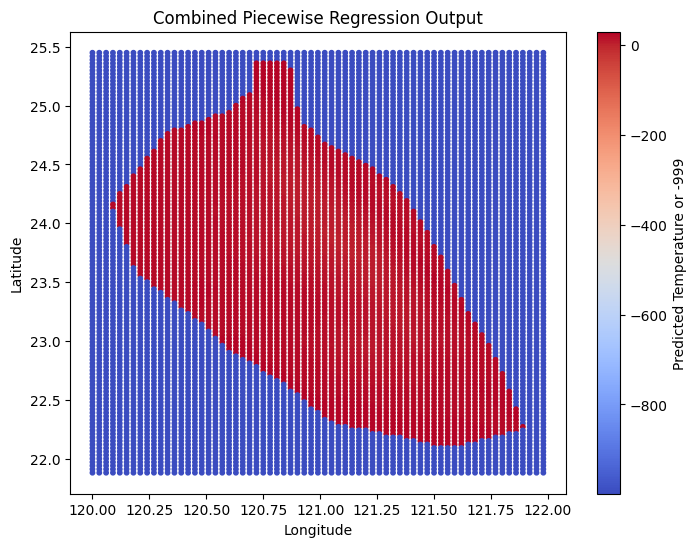

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sc = plt.scatter(results[:,0],results[:,1], c=y_combined, cmap='coolwarm', s=10)
plt.colorbar(sc, label="Predicted Temperature or -999")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Combined Piecewise Regression Output")
plt.show()

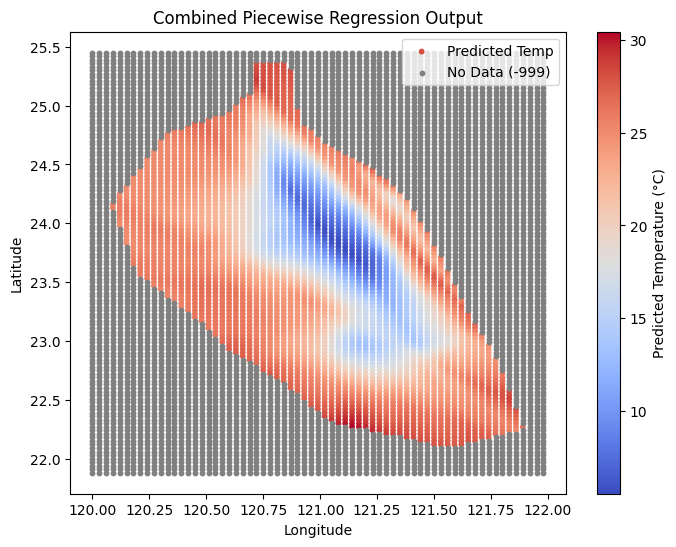

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 分開有效與無效點
valid_mask = y_combined != -999
invalid_mask = y_combined == -999

# 畫圖
plt.figure(figsize=(8, 6))

# 畫有效點（有溫度的點）
sc = plt.scatter(results[valid_mask, 0], results[valid_mask, 1],
                 c=y_combined[valid_mask], cmap='coolwarm', s=10, label="Predicted Temp")

# 畫無效點（預測不到的區域）
plt.scatter(results[invalid_mask, 0], results[invalid_mask, 1],
            color='gray', s=10, label="No Data (-999)")

plt.colorbar(sc, label="Predicted Temperature (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Combined Piecewise Regression Output")
plt.legend()
plt.show()